In [1]:
%matplotlib inline

In [2]:
# Uses the exact data set and permutation from the psMNIST task in
# Towards Non-saturating Recurrent Units for Modelling Long-term Dependencies

import os
import sys
import numpy as np
import tensorflow as tf

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
# Set seed to ensure this example is reproducible
seed = 0
tf.random.set_seed(seed)
np.random.seed(seed)
rng = np.random.RandomState(seed)

# load mnist dataset
(train_images, train_labels), (test_images, test_labels) = (
    tf.keras.datasets.mnist.load_data())

# Change inputs to 0--1 range
train_images = train_images / 255
test_images = test_images / 255

# Flatten images into sequences
train_images = train_images.reshape((train_images.shape[0], -1, 1))
test_images = test_images.reshape((test_images.shape[0], -1, 1))

# Apply permutation
perm = rng.permutation(train_images.shape[1])
train_images = train_images[:, perm]
test_images = test_images[:, perm]

X_train = train_images[0:50000]
X_valid = train_images[50000:]
X_test = test_images

Y_train = train_labels[0:50000]
Y_valid = train_labels[50000:]
Y_test = test_labels

print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)
print(X_test.shape, Y_test.shape)

(50000, 784, 1) (50000,)
(10000, 784, 1) (10000,)
(10000, 784, 1) (10000,)


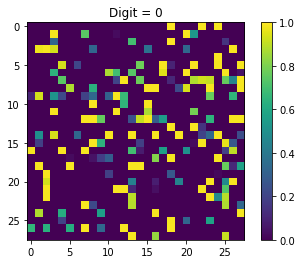

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.subplot(111)
plt.title("Digit = %d" % Y_train[1])
plt.imshow(X_train[1].reshape(28, 28))
plt.colorbar()
plt.show()

In [5]:
from lmu import LMUCell

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.core import Dense
from keras.layers.recurrent import RNN
from keras.models import Sequential, Model
from keras.initializers import Constant
from keras.utils import multi_gpu_model, to_categorical

Using TensorFlow backend.


In [6]:
padded_length = 28**2 + 1
n_pixels = padded_length - 1

def lmu_layer(**kwargs):
    return RNN(LMUCell(units=212,
                       order=256,
                       theta=n_pixels,
                       input_encoders_initializer=Constant(1),
                       hidden_encoders_initializer=Constant(0),
                       memory_encoders_initializer=Constant(0),
                       input_kernel_initializer=Constant(0),
                       hidden_kernel_initializer=Constant(0),
                       memory_kernel_initializer='glorot_normal',
                      ),
               return_sequences=False,
               **kwargs
              )

model = Sequential()
model.add(lmu_layer(
    input_shape=X_train.shape[1:],  # (nr. of pixels, 1)
))
model.add(Dense(10, activation='softmax'))

model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn_1 (RNN)                  (None, 212)               165689    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2130      
Total params: 167,819
Trainable params: 102,027
Non-trainable params: 65,792
_________________________________________________________________


In [7]:
import time

batch_size = 100
epochs = 10
t = time.time()

fname = "./psMNIST-standard.hdf5"
callbacks = [
    # CSVLogger('log-ctn19-pmnist-dn-090419.csv', append=True, separator=';')
    # EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=5),
    ModelCheckpoint(filepath=fname, monitor='val_loss', verbose=1, save_best_only=True),
]

result = model.fit(
    X_train,
    to_categorical(Y_train),
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_valid, to_categorical(Y_valid)),
    callbacks=callbacks
)

print("Took {:.2f} min".format((time.time() - t) / 60))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 567s 11ms/step - loss: 0.4536 - accuracy: 0.8663 - val_loss: 0.2895 - val_accuracy: 0.9144

Epoch 00001: val_loss improved from inf to 0.28947, saving model to ../models/psMNIST-standard.hdf5
Epoch 2/10
50000/50000 [==============================] - 544s 11ms/step - loss: 0.2629 - accuracy: 0.9211 - val_loss: 0.1970 - val_accuracy: 0.9422

Epoch 00002: val_loss improved from 0.28947 to 0.19698, saving model to ../models/psMNIST-standard.hdf5
Epoch 3/10
50000/50000 [==============================] - 584s 12ms/step - loss: 0.1820 - accuracy: 0.9451 - val_loss: 0.1525 - val_accuracy: 0.9544

Epoch 00003: val_loss improved from 0.19698 to 0.15249, saving model to ../models/psMNIST-standard.hdf5
Epoch 4/10
50000/50000 [==============================] - 551s 11ms/step - loss: 0.1355 - accuracy: 0.9591 - val_loss: 0.1254 - val_accuracy: 0.9628

Epoch 00004: val_loss improved from 0.1524

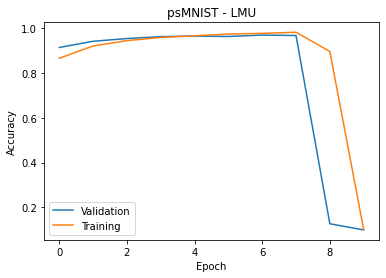

In [8]:
plt.figure()
plt.plot(result.history['val_accuracy'], label="Validation")
plt.plot(result.history['accuracy'], label="Training")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("psMNIST - LMU")
plt.show()

In [9]:
saved_epoch = np.argmin(result.history['val_loss'])
result.history['val_accuracy'][saved_epoch]

0.09910000115633011

In [10]:
model.load_weights(fname)  # load best weights

In [11]:
model.evaluate(X_test, to_categorical(Y_test))

10000/10000 [==============================] - 34s 3ms/step


[0.10887054147776216, 0.9674999713897705]

In [12]:
import pickle
with open('psMNIST-standard.pkl', 'wb') as f:
    pickle.dump(result, f)